# Praca domowa 5 Marcin Wilk

Naszym zadaniem będzie klasteryzacja danych ze zbioru clustering 2 sposobami oraz wybór optymalnej liczby klastrów.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("C:\\Users\\Lenovo\\Desktop\\Wstęp do uczenia maszynowego\\Dane\\clustering.csv",header=None)

In [3]:
df.head(10)

,0,1
0,41.788907,52.220182
1,-96.586516,90.957033
2,-54.143591,-99.153377
3,19.929231,-45.859779
4,-82.941076,84.099186
5,13.389996,-4.016202
6,-26.104987,8.618031
7,-15.625451,67.370573
8,85.259069,14.681990
9,33.039866,-49.611486


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       400 non-null    float64
 1   1       400 non-null    float64
dtypes: float64(2)
memory usage: 6.4 KB


In [5]:
df.columns = ["x","y"]

Widzimy, że nasze dane mają dość prostą strukturę, są to dwie numeryczne kolumny, bez żadnych pustych wartości. Dzięki temu, że są one dwuwymiarowe możemy łatwo je sobie zwizualizować. Może dzięki temu dostrzeżemy jakąś prawidłowość, która później okaże się przydatna.

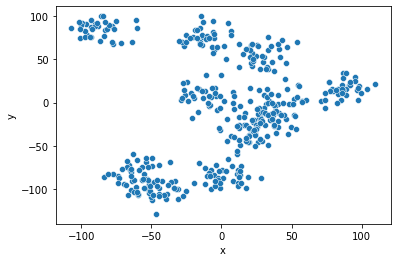

In [6]:
sns.scatterplot(x=df.x,y=df.y,)
plt.show()

Ułożenie punktów wydaje się być nieprzypadkowe, nawet na oko jesteśmy w stanie wyróżnić pewne klastry. Przykładem takiego jest zbiór punktów w lewym górnym rogu rysunku, wyraźnie odstaje on od pozostałej chmury punktów.

## Metoda k-medoidów

Pierwszym naszym podejściem będzie metoda k-medoidów, która nieco przypomina metodę k-średnich, jednak centrami klastrów mogą być w tym przypadków tylko punkty należące do tego zbioru. Dzięki temu mamy lepszą interpretowalność centrów klastrów, gdyż nie mogą to być nowo powstałe punkty, które mogłyby być zupełnie "oderwane" od naszych danych. Tutaj również musimy podać liczbę klastrów przed wykonywaniem algorytmu. Do wyboru optymalnej liczby klastrów wykorzystamy metodę tzw. łokcia.

In [7]:
from sklearn_extra.cluster import KMedoids

In [8]:
#kod z zajęć
def count_wcss_scores(X, k_max):
    #  WCSS = within-cluster sum of squares
    scores = []
    for k in range(1, k_max+1):
        kmedoids = KMedoids(n_clusters=k, random_state=0)
        kmedoids.fit(X)
        wcss = kmedoids.inertia_
        scores.append(wcss)
    return scores

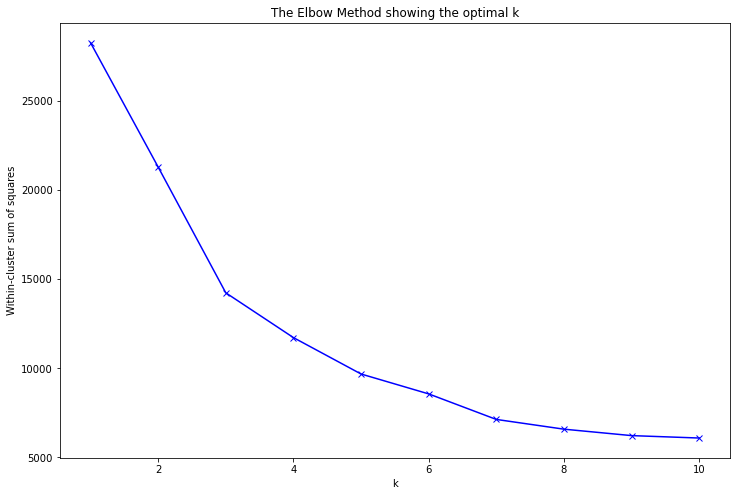

In [9]:
wcss_vec = count_wcss_scores(df, 10)
x_ticks = list(range(1, len(wcss_vec) + 1))
f = plt.figure(figsize=(12, 8))
plt.plot(x_ticks, wcss_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Metoda łokcia nie daje tutaj jednoznacznych wyników. Teoretycznie największe załamanie jest dla k=3, ale WCSS dalej jest duże w tym przypadku i dla kolejnych k spadek jest dalej dość wyraźny. Zobaczmy graficznie jak wyglądają klastry dla k=3.

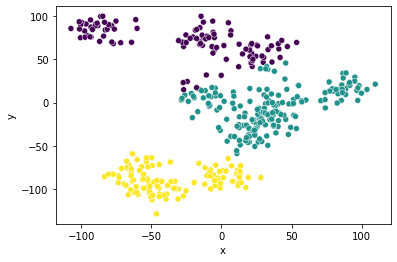

In [10]:
kmedoids = KMedoids(n_clusters=3, random_state=0)
kmedoids.fit(df)
labels = kmedoids.labels_
sns.scatterplot(x=df.x,y=df.y,c=labels)
plt.show()

W moim odczuciu k=3 nie daje nam optymalnego podziału, chcielibyśmy np. aby chmura w lewym górnym rogu była oddzielnym klastrem, gdyż występuje teraz w jednym klastrze z punktami, które są od niej wyraźnie oddzielone.

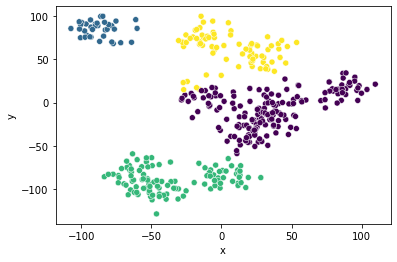

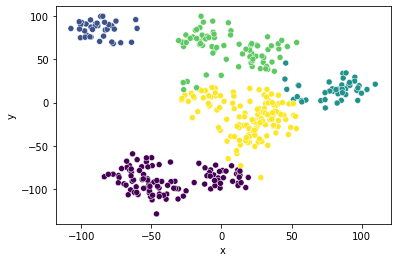

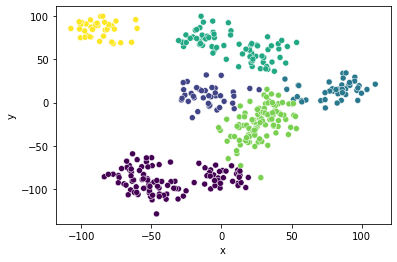

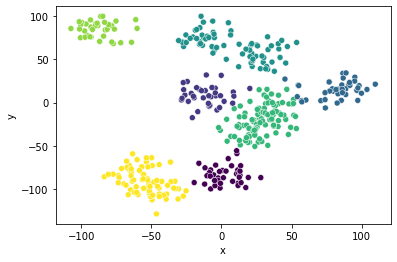

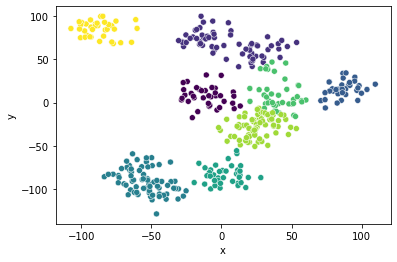

In [11]:
for i in range(4,9):
    kmedoids = KMedoids(n_clusters=i, random_state=0)
    kmedoids.fit(df)
    labels = kmedoids.labels_
    sns.scatterplot(x=df.x,y=df.y,c=labels)
    plt.show()

Już dla k=4 mamy oddzieloną naszą chmurę punktów od reszty. Wizualnie najbardziej odpowiedni wydaje się jednak podział dla k=7. Da się dostrzec, że większość grup ma spore odstępy między sobą. Żadne dwie grupy nie wydają się też być na siłę rozdzielone od siebie. Metoda łokcia nie dała tutaj jednoznacznych wyników, ale myślę, że w połączeniu z wizualizacją można uznać, że optymalna liczba klastrów dla tej metody wynosi 7.

## Metoda aglomeracyjna

Drugą metodą której użyjemy do podziału będzie hierarchiczna metoda aglomeracyjna. Użyjemy do niej single linkage, gdyż chcemy, aby klastry były od siebie jak najbardziej odległe. Tym razem nie będziemy zadawać z góry liczby klastrów, lecz użyjemy parametru *distance_threshold*, dzięki któremu liczba klastrów dobierze się sama. Jak chcemy jednak znaleźć optymalny *distance_threshold*? Posłużymy się metodą silhouette i przedstawimy na wykresie zależność tej metryki od *distance_threshold*.

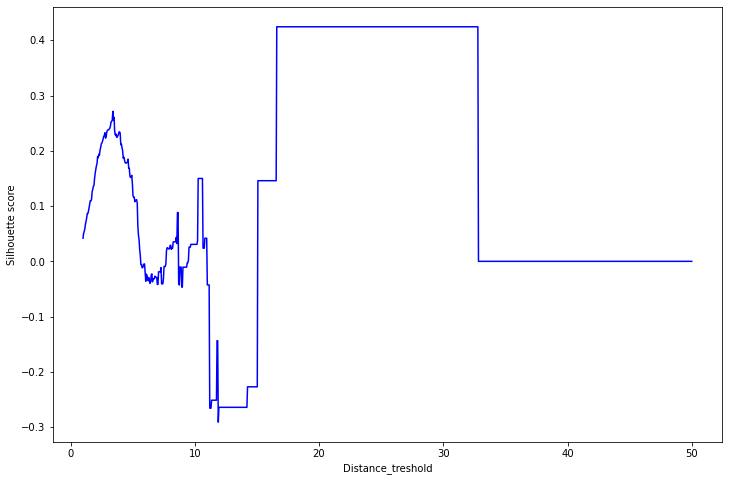

In [18]:
dt=np.linspace(start=1, stop=50, num=1000)
sil_score=np.zeros(1000)
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
for i in range(1000):
    model=AgglomerativeClustering(n_clusters=None, linkage='single', distance_threshold=dt[i])
    labels=model.fit_predict(df)
    if len(set(labels))==1:
        sil_score[i]=0
    else:
        sil_score[i]=silhouette_score(df,labels)
f = plt.figure(figsize=(12,8))
plt.plot(dt, sil_score, 'b-')
plt.xlabel('Distance_treshold')
plt.ylabel('Silhouette score')
plt.show()

Na wykresie można dostrzec ciekawą zależność. Dla małego tresholdu (1-5) mamy raczej dobre dopasowanie. Potem w przedziale 5-15 mamy słabe dopasowanie. Dla kolejnych wartości mamy stałe, teoretycznie najlepsze dopasowanie. Powyżej pewnego progu nasz silhouette_score jest już stale równy zero, co prawdopodobnie oznacza jeden klaster. Zobaczmy ile klastrów mamy dla tresholdów 4 i 20 oraz jak takie podziały prezentują się graficznie.

Treshold=4

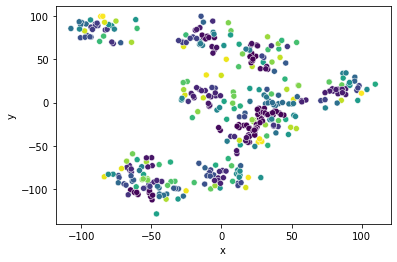

In [21]:
model=AgglomerativeClustering(n_clusters=None, linkage='single', distance_threshold=4)
labels=model.fit_predict(df)
sns.scatterplot(x=df.x,y=df.y,c=labels)
plt.show()

Podział jest totalnie wymieszany, klastry w ogóle nie są rozłączne i przecinają się wzajemnie. Ich liczba wynosi natomiast.

In [22]:
len(set(labels)) #liczba klastrów w tym podziale

198

Jest jeszcze gorzej niż się spodziewaliśmy, okazuje się, że klastry mogą nie być wymieszane, a po prostu jest ich tak dużo, że ja nie umiem rozróżnić tylu kolorów xD

Treshold=20

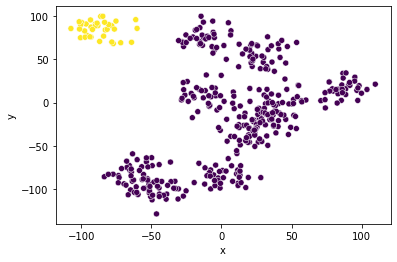

In [23]:
model=AgglomerativeClustering(n_clusters=None, linkage='single', distance_threshold=20)
labels=model.fit_predict(df)
sns.scatterplot(x=df.x,y=df.y,c=labels)
plt.show()

Takiego wyniku mogliśmy się właśnie spodziewać. Łatwo zauważyć dlaczego silhouette_score stabilizuje się w pewnym momencie. Dla takich tresholdów jest po prostu tworzony zawsze ten sam podział. Żółta grupa jest wyraźnie odstająca od reszty dlatego właśnie w przypadku single linkage bedzie ona wybierana jako odzielna. Sprawdźmy jeszcze jakie wyniki otrzymamy w przypadku innej opcji linkage.

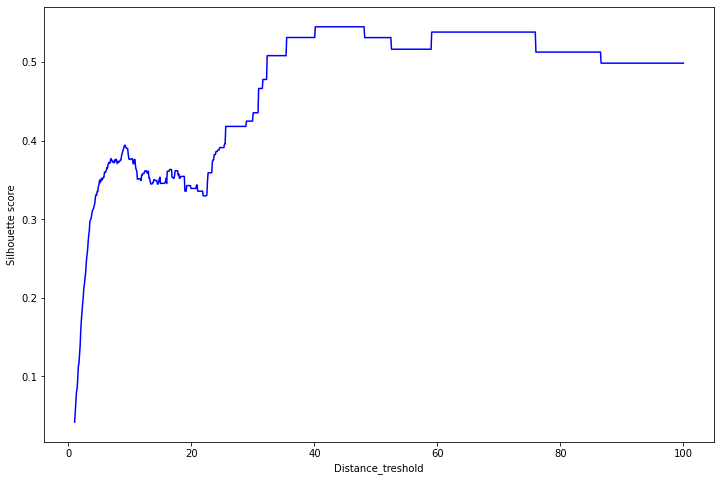

In [29]:
dt=np.linspace(start=1, stop=100, num=1000)
sil_score=np.zeros(1000)
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
for i in range(1000):
    model=AgglomerativeClustering(n_clusters=None, linkage='average', distance_threshold=dt[i])
    labels=model.fit_predict(df)
    if len(set(labels))==1:
        sil_score[i]=0
    else:
        sil_score[i]=silhouette_score(df,labels)
f = plt.figure(figsize=(12,8))
plt.plot(dt, sil_score, 'b-')
plt.xlabel('Distance_treshold')
plt.ylabel('Silhouette score')
plt.show()

Dla linakge='average' silhouette_score wygląda dużo lepiej, nie mamy nigdzie w naszym przedziale wartości zerowych oraz ujemnych. Sprawdzimy jak wyglądają podziały dla tresholdów 10 i 40.

Treshold=10

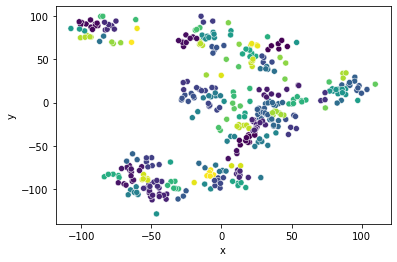

In [26]:
model=AgglomerativeClustering(n_clusters=None, linkage='average', distance_threshold=10)
labels=model.fit_predict(df)
sns.scatterplot(x=df.x,y=df.y,c=labels)
plt.show()

In [27]:
len(set(labels)) #liczba klastrów w tym podziale

96

Kolejny raz mamy do czynienia z za dużą liczbą klastrów, więc od razu odrzucamy taki podział.

Treshold=40

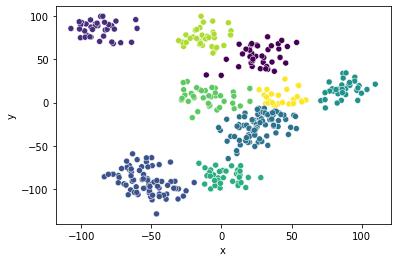

In [28]:
model=AgglomerativeClustering(n_clusters=None, linkage='average', distance_threshold=40)
labels=model.fit_predict(df)
sns.scatterplot(x=df.x,y=df.y,c=labels)
plt.show()

Taki podział z 9 klastrami wydaje się być bardzo sensowny. silhouette_score wynosi w tym przypadku ponad 0.5 co może świadczyć o tym, że nasz podział jest w miarę dobry. Uznajemy więc, że parametr distance_threshold=40 oraz linkage='average' wybiera nam optymalny podział z 9 klastrami.

Zobaczmy jeszcze na koniec czy w przypadku pozostałych linkage mamy znaczącą różnicę, jeśli chodzi o silhouette_score.

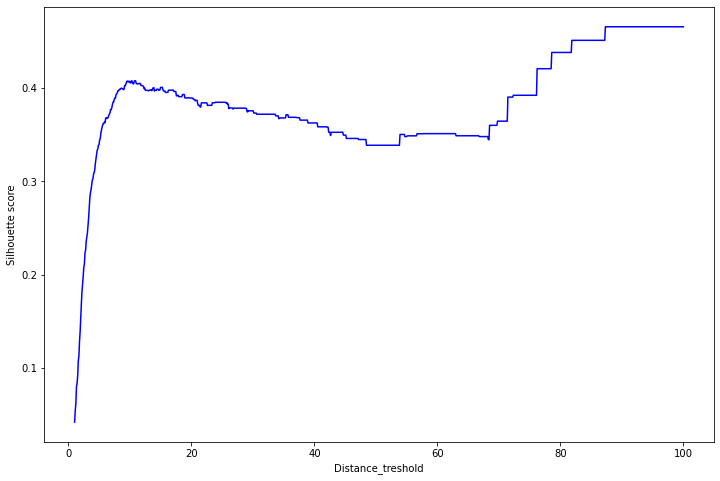

In [30]:
dt=np.linspace(start=1, stop=100, num=1000)
sil_score=np.zeros(1000)
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
for i in range(1000):
    model=AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=dt[i])
    labels=model.fit_predict(df)
    if len(set(labels))==1:
        sil_score[i]=0
    else:
        sil_score[i]=silhouette_score(df,labels)
f = plt.figure(figsize=(12,8))
plt.plot(dt, sil_score, 'b-')
plt.xlabel('Distance_treshold')
plt.ylabel('Silhouette score')
plt.show()

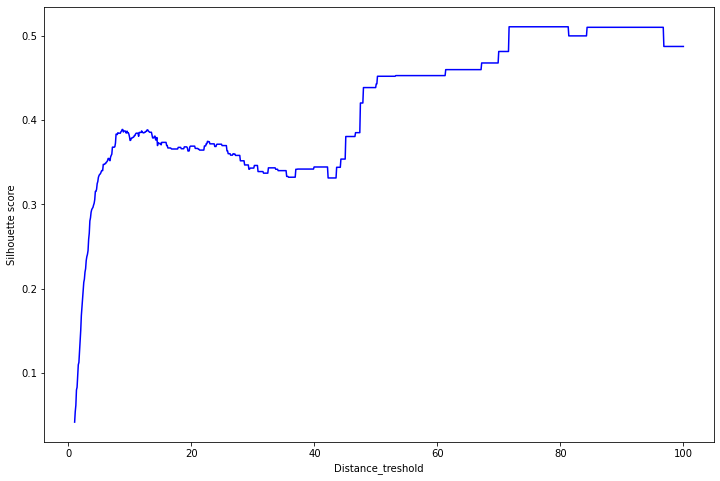

In [31]:
dt=np.linspace(start=1, stop=100, num=1000)
sil_score=np.zeros(1000)
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
for i in range(1000):
    model=AgglomerativeClustering(n_clusters=None, linkage='complete', distance_threshold=dt[i])
    labels=model.fit_predict(df)
    if len(set(labels))==1:
        sil_score[i]=0
    else:
        sil_score[i]=silhouette_score(df,labels)
f = plt.figure(figsize=(12,8))
plt.plot(dt, sil_score, 'b-')
plt.xlabel('Distance_treshold')
plt.ylabel('Silhouette score')
plt.show()

Widzimy, że nie ma tutaj znaczącej poprawy, zatem zostajemy przy naszym wcześniejszym podziale z linkage='average'.